# Lab 3: Q-learning
## Environment Setup

In [2]:
import os
# You will need numpy and gym. You can try running the following lines to install them
# The assignment is tested on Python3.8 so in case you are having installation issues you might
# want to try installing that version.

!{os.sys.executable} -m pip install numpy
!{os.sys.executable} -m pip install gymnasium
!{os.sys.executable} -m pip install Pillow
!{os.sys.executable} -m pip install ipython
!{os.sys.executable} -m pip install pygame

import gymnasium as gym
import numpy as np
import random
from PIL import Image
from IPython.display import display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00


Number of States 16, Number of Actions 4
Reward range (0, 1)


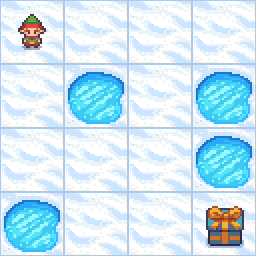

In [3]:
# Import the environment we will use in this assignment
env=gym.make('FrozenLake-v1',is_slippery=False, render_mode="rgb_array").unwrapped

# Show the model
print(f"Number of States {env.observation_space.n}, Number of Actions {env.action_space.n}")
print(f"Reward range {env.reward_range}")
# reset the environment
env.reset()
# visualize the current state
display(Image.fromarray(env.render()))

## Set Parameters

In [6]:
# Training parameters common to both methods.
state_size = env.observation_space.n
action_size = env.action_space.n
num_episodes = 2000
max_steps = 100
alpha = 0.8        # Learning rate
gamma = 0.95       # Discount factor
epsilon_init = 1.0 # Initial exploration rate
epsilon_min = 0.01 # Minimum exploration rate
epsilon_decay = 0.995

## Part 1: Q-Table Based Q-Learning
### Task 1: Complete the table-based Q-learning algorithm
**Coding Instructions:**
1. First, you need to complete the epsilon-greedy action selection. In each eposide we have an exploration rate *epsilon*. Compare a random number with epsilon: If the random number is less than epsilon, explore by choosing a random action. Otherwise, exploit by choosing the action with the highest Q-value in the current state.
   
2. Second, you need to do Q-learning update. You may consider update the Q-value via the following equation:  
$$
Q(\text{state}, action) \leftarrow Q(\text{state}, action)
\;+\; \alpha
\Bigl[
  R_t + \gamma \max_a Q(\text{next\_state}, a)
  \;-\;
  Q(\text{state}, action)
\Bigr]
$$
This incrementally updates the Q-value estimate toward the immediate reward + discounted best future Q-value. Over many episodes, the Q-table converges to accurate estimates of how good each (state, action) pair is, assuming sufficient exploration and proper hyperparameters.

3. Third, after each episode, you typically decrease (or “decay”) epsilon so the agent explores less over time. A common formular is
$$
\epsilon \leftarrow \max\bigl(\epsilon \times \epsilon_{\text{decay}},\; \epsilon_{\min}\bigr)
$$


In [4]:
def train_q_table(num_episodes, max_steps, alpha, gamma,
                  epsilon_init, epsilon_min, epsilon_decay):
    """
    Trains a Q-learning agent in the FrozenLake-v1 environment.
    """
    state_size = env.observation_space.n
    action_size = env.action_space.n

    Q = np.zeros((state_size, action_size))
    epsilon = epsilon_init
    rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0

        for step in range(max_steps):
            ##########TODO: Implement the epsilon-greedy action selection##########
            random_value = np.random.rand()
            if random_value < epsilon:
              action = np.random.choice(action_size)
            else:
              action = np.argmax(Q[state, :])
            #######################################################################

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            ##########TODO: Implement the Q-learning update ##################
            Q[state, action] = Q[state, action] + alpha * (reward + gamma * max(Q[state,:]) - Q[state,action])
            ################################################################

            state = next_state
            total_reward += reward

            if done:
                break

        ############TODO: Implement the epsilon decay####################
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        ##################################################################

        rewards.append(total_reward)

        # Optional logging every 500 episodes
        if (episode + 1) % 500 == 0:
            print(f"Q-table - Episode {episode+1}/{num_episodes} "
                  f"- Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return Q, rewards

### Call the Q-learning function and visualize the policy

In [7]:
print("Training Q-table agent...")
Q_table, rewards_q_table = train_q_table(num_episodes, max_steps, alpha, gamma,
                                           epsilon_init, epsilon_min, epsilon_decay)

Training Q-table agent...
Q-table - Episode 500/2000 - Reward: 0.0, Epsilon: 0.082
Q-table - Episode 1000/2000 - Reward: 0.0, Epsilon: 0.010
Q-table - Episode 1500/2000 - Reward: 0.0, Epsilon: 0.010
Q-table - Episode 2000/2000 - Reward: 0.0, Epsilon: 0.010


In [9]:
# -------------------------------
# Policy Visualization Functions
# -------------------------------
def visualize_policy_from_q(Q):
    """
    Visualizes the learned policy from a Q-table.
    Frozen cells ('F') are replaced by arrows indicating the best action.
    """
    action_symbols = {0: '<', 1: 'v', 2: '>', 3: '^'}
    grid = env.desc.astype('U')
    policy_grid = np.copy(grid)
    n_rows, n_cols = grid.shape
    for row in range(n_rows):
        for col in range(n_cols):
            state_index = row * n_cols + col
            if grid[row, col] == 'F':
                best_action = np.argmax(Q[state_index])
                policy_grid[row, col] = action_symbols[best_action]
    for row in policy_grid:
        print(" ".join(row))

print("\nLearned Policy from Q-table Agent:")
visualize_policy_from_q(Q_table)



Learned Policy from Q-table Agent:
S < < <
< H < H
< < < H
H < > G


## Part 2: Linear Q-Function Approximator
### Task 2: Read through the code
In this part there is no coding tasks, but you need to carefully read through and understand the implementation of Q-Function Approximator, which should be also **included in your report**.

External learning resources:
- https://gibberblot.github.io/rl-notes/single-agent/function-approximation.html
- https://danieltakeshi.github.io/2016/10/31/going-deeper-into-reinforcement-learning-understanding-q-learning-and-linear-function-approximation/
- https://www.youtube.com/watch?v=wAk1lxmiW4c

In [10]:
class LinearQAgent:
    def __init__(self, state_size, action_size, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.weights = np.zeros((state_size, action_size))

    def act(self, state):
        """Epsilon-greedy action selection."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # random action
        # Exploit: linear model simply picks argmax among w[state]
        return np.argmax(self.weights[state])

    def update(self, state, action, reward, next_state, done):
        """Perform a Q-learning update with linear approximation."""
        q_value = self.weights[state, action]
        next_q = np.max(self.weights[next_state]) if not done else 0.0
        # Q-learning update rule
        difference = reward + self.gamma * next_q - q_value
        self.weights[state, action] += self.alpha * difference

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def predict(self, state):
        """
        Returns a NumPy array of Q-values for all actions at the given state.
        Useful for visualizing or evaluating the learned policy.
        """
        return self.weights[state]


In [11]:
def train_linear_agent(
    num_episodes,
    max_steps,
    alpha,
    gamma,
    epsilon,
    epsilon_min,
    epsilon_decay
):
    """
    Trains a Q-learning agent using a linear function approximator in a Gym/Gymnasium environment.
    """

    # Derive state_size and action_size
    # If the environment is discrete (like FrozenLake), we can do:
    state_size = env.observation_space.n
    action_size = env.action_space.n

    # Initialize the Linear Q agent
    agent = LinearQAgent(state_size, action_size, alpha, gamma, epsilon, epsilon_min, epsilon_decay)
    rewards = []

    for episode in range(num_episodes):
        # For Gymnasium or Gym >= 0.26, reset() returns (obs, info)
        state, _ = env.reset()
        total_reward = 0

        for step in range(max_steps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update the agent
            agent.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            if done:
                break

        # Decay epsilon at the end of each episode
        agent.decay_epsilon()
        rewards.append(total_reward)

        if (episode + 1) % 500 == 0:
            print(f"Linear Q - Episode {episode+1}/{num_episodes} - Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

    env.close()
    return agent, rewards

### Call the Q-learning function and visualize the policy

In [12]:
print("\nTraining Linear Q-function agent...")
linear_agent, rewards_linear = train_linear_agent(num_episodes, max_steps, alpha, gamma,
                                                    epsilon_init, epsilon_min, epsilon_decay)


Training Linear Q-function agent...
Linear Q - Episode 500/2000 - Reward: 0.0, Epsilon: 0.082
Linear Q - Episode 1000/2000 - Reward: 1.0, Epsilon: 0.010
Linear Q - Episode 1500/2000 - Reward: 1.0, Epsilon: 0.010
Linear Q - Episode 2000/2000 - Reward: 1.0, Epsilon: 0.010


In [13]:
def visualize_policy_from_linear(agent):
    """
    Visualizes the learned policy from the linear Q-function approximator.
    In FrozenLake, frozen cells ('F') are replaced by arrows indicating the best action.
    """
    action_symbols = {0: '<', 1: 'v', 2: '>', 3: '^'}

    # Access the underlying desc (ASCII map) as a character array.
    # For Gymnasium/Gym v0.26+, often it is env.unwrapped.desc
    grid = env.unwrapped.desc.astype('U')  # 'U' => Unicode string type
    policy_grid = np.copy(grid)
    n_rows, n_cols = grid.shape

    for row in range(n_rows):
        for col in range(n_cols):
            # Convert (row, col) to state index in FrozenLake
            state_index = row * n_cols + col

            # Only overwrite if the cell is 'F' (frozen)
            if grid[row, col] == 'F':
                # agent.predict(state_index) should return a Q-value array [Q(s,a0), Q(s,a1), ...]
                q_values = agent.predict(state_index)
                best_action = np.argmax(q_values)
                policy_grid[row, col] = action_symbols[best_action]

    # Print the resulting policy map
    for row_content in policy_grid:
        print(" ".join(row_content))

print("\nLearned Policy from Linear Q-function Agent:")
visualize_policy_from_linear(linear_agent)



Learned Policy from Linear Q-function Agent:
S < v <
v H v H
> v v H
H > > G


## Part 3: Comparsion of Q-Table with Q-function

In [14]:
import numpy as np

num_episodes = 5000
max_steps = 100
alpha = 0.1
gamma = 0.99
epsilon_init = 1.0
epsilon_min = 0.01
epsilon_decay = 0.999

# Train the tabular Q agent
q_table, rewards_tabular = train_q_table(num_episodes, max_steps,
                                         alpha, gamma,
                                         epsilon_init, epsilon_min,
                                         epsilon_decay)

# Train the linear Q agent
linear_agent, rewards_linear = train_linear_agent(
    num_episodes=num_episodes,
    max_steps=max_steps,
    alpha=alpha,
    gamma=gamma,
    epsilon=epsilon_init,
    epsilon_min=epsilon_min,
    epsilon_decay=epsilon_decay
)

Q-table - Episode 500/5000 - Reward: 0.0, Epsilon: 0.606
Q-table - Episode 1000/5000 - Reward: 0.0, Epsilon: 0.368
Q-table - Episode 1500/5000 - Reward: 0.0, Epsilon: 0.223
Q-table - Episode 2000/5000 - Reward: 0.0, Epsilon: 0.135
Q-table - Episode 2500/5000 - Reward: 0.0, Epsilon: 0.082
Q-table - Episode 3000/5000 - Reward: 0.0, Epsilon: 0.050
Q-table - Episode 3500/5000 - Reward: 0.0, Epsilon: 0.030
Q-table - Episode 4000/5000 - Reward: 0.0, Epsilon: 0.018
Q-table - Episode 4500/5000 - Reward: 0.0, Epsilon: 0.011
Q-table - Episode 5000/5000 - Reward: 0.0, Epsilon: 0.010
Linear Q - Episode 500/5000 - Reward: 0.0, Epsilon: 0.606
Linear Q - Episode 1000/5000 - Reward: 1.0, Epsilon: 0.368
Linear Q - Episode 1500/5000 - Reward: 0.0, Epsilon: 0.223
Linear Q - Episode 2000/5000 - Reward: 0.0, Epsilon: 0.135
Linear Q - Episode 2500/5000 - Reward: 1.0, Epsilon: 0.082
Linear Q - Episode 3000/5000 - Reward: 1.0, Epsilon: 0.050
Linear Q - Episode 3500/5000 - Reward: 1.0, Epsilon: 0.030
Linear Q 

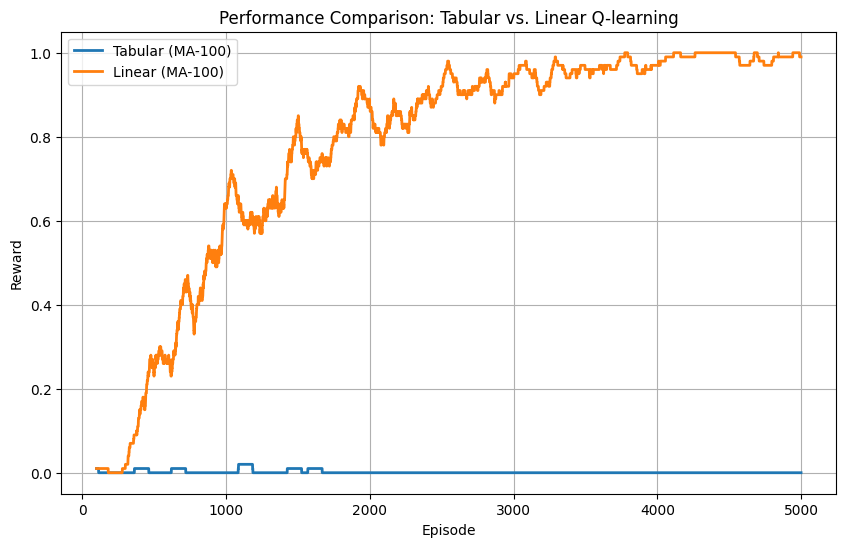

In [15]:
import matplotlib.pyplot as plt

# Create an array of episodes for the x-axis
episodes = np.arange(num_episodes)

plt.figure(figsize=(10, 6))

window_size = 100
rolling_tabular = np.convolve(rewards_tabular, np.ones(window_size)/window_size, mode='valid')
rolling_linear = np.convolve(rewards_linear, np.ones(window_size)/window_size, mode='valid')

# Adjust the x-axis for the rolling averages
rolling_episodes = np.arange(window_size - 1, num_episodes)

plt.plot(rolling_episodes, rolling_tabular, label=f"Tabular (MA-{window_size})", linewidth=2.0)
plt.plot(rolling_episodes, rolling_linear, label=f"Linear (MA-{window_size})", linewidth=2.0)

plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Performance Comparison: Tabular vs. Linear Q-learning")
plt.legend()
plt.grid(True)
plt.show()


## (Bonus) Part 4: Deep Q-Learning
This is a bonus part including two tasks: Task 3 and Task 4, which is not compulsory to finish. If you complete this part and get correct results, one extra point will be added to your grade.

External learning resources:
- https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm
- https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae
- https://www.youtube.com/watch?v=wDVteayWWvU
### Task 3: Complete the Deep Q-learning network architecture

In [16]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=32):
        super(DQNetwork, self).__init__()

        #######TODO: Implement the network architecture########
        # here is a simple network with one hidden layer, you can try different architectures
        # and parameters to improve the performance
        # self.net = nn.Sequential(
        #     nn.Linear(state_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, action_size)
        # )
        #######################################################
        self.net = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.linear(hidden_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size)
        )


    def forward(self, x):
        return self.net(x)


### Defionition of helper functions

In [17]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

In [18]:
def one_hot_encode(state_idx, state_size):
    vec = np.zeros(state_size, dtype=np.float32)
    vec[state_idx] = 1.0
    return vec

def select_action(network, state, epsilon, action_size):
    """
    Epsilon-greedy policy.
    'state' is a 1D PyTorch tensor (already one-hot encoded).
    """
    if np.random.rand() < epsilon:
        return np.random.randint(action_size)
    else:
        with torch.no_grad():
            q_values = network(state)
            return torch.argmax(q_values).item()


### Task 4: Complete the training steps of Deep Q-learning
In this task you need to complete the training function of Deep Q-learning. Most of the code are ready for you, only some key parts are masked out.

**Coding Instructions:**
1. Forward the Q-network for current states: You already have a batch of current states in states_t (shape [batch_size, state_dim]). Simply pass states_t through your Q-network to get the Q-values for each action.
2. Forward the Q-network for next states and compute max *Q*: Pass the next states in next_states_t through the Q-network. Then take the max across actions to get the best possible future Q-value for each next state. We usually do this under a torch.no_grad() context or detach the graph, because we do not want to backpropagate through the next state’s Q-values in standard DQN.
3. Decay the epsilon as in previous tasks.

In [ ]:
def train_dqn_frozenlake(
    env_name="FrozenLake-v1",
    num_episodes=2000,
    max_steps=100,
    gamma=0.99,
    lr=1e-3,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.999,
    batch_size=32,
    replay_capacity=10000,
    hidden_size=32
):
    # 1. Create environment
    env = gym.make(env_name, is_slippery=True)
    state_size = env.observation_space.n
    action_size = env.action_space.n

    # 2. Initialize network & optimizer
    q_network = DQNetwork(state_size, action_size, hidden_size)
    optimizer = optim.Adam(q_network.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # 3. Initialize replay buffer
    replay_buffer = ReplayBuffer(capacity=replay_capacity)

    # 4. Epsilon initialization
    epsilon = epsilon_start

    # 5. For logging
    rewards_per_episode = []

    for episode in range(num_episodes):
        # Gymnasium: reset() returns (obs, info)
        state_idx, _ = env.reset()
        total_reward = 0

        for step in range(max_steps):
            # Convert state to one-hot + torch tensor
            state_oh = torch.tensor(one_hot_encode(state_idx, state_size), dtype=torch.float32).unsqueeze(0)

            # Select action
            action = select_action(q_network, state_oh, epsilon, action_size)

            # Step in the environment
            next_state_idx, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store transition in buffer
            next_state_oh = one_hot_encode(next_state_idx, state_size)
            replay_buffer.push(state_oh.squeeze(0).numpy(), action, reward, next_state_oh, done)

            state_idx = next_state_idx
            total_reward += reward

            # Train the network if replay buffer has enough samples
            if len(replay_buffer) >= batch_size:
                # Sample a mini-batch
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Convert all to tensors
                states_t = torch.tensor(states, dtype=torch.float32)      # (batch_size, state_size)
                actions_t = torch.tensor(actions, dtype=torch.long)       # (batch_size,)
                rewards_t = torch.tensor(rewards, dtype=torch.float32)    # (batch_size,)
                next_states_t = torch.tensor(next_states, dtype=torch.float32)
                dones_t = torch.tensor(dones, dtype=torch.float32)        # (batch_size,)

                #########TODO: forward the Q-network and compute the loss########
                q_values = # Your code here
                #################################################################

                # Gather the Q-value for the chosen action: shape (batch_size,)
                q_values_current = q_values.gather(1, actions_t.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    #########TODO: forward Q-network again for next states and compute the max Q-value########
                    q_next_max = # Your code here
                    ##########################################################################################

                # Target: y = r + gamma * max Q(next_state) if not done
                q_targets = rewards_t + gamma * q_next_max * (1 - dones_t)

                loss = loss_fn(q_values_current, q_targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        ######################TODO: Decay epsilon#####################
        epsilon = # Your code here
        ##############################################################

        rewards_per_episode.append(total_reward)

        # Optional logging
        if (episode + 1) % 200 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Reward: {total_reward:.1f}, Epsilon: {epsilon:.3f}")

    env.close()
    return q_network, rewards_per_episode


### Call the Deep Q-learning function and visualize the reward across training episodes

In [ ]:
q_network, rewards = train_dqn_frozenlake(num_episodes=2000)

In [ ]:
import matplotlib.pyplot as plt

window_size = 100
rolling_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(rolling_rewards)
plt.title("DQN Training: Rolling Rewards")
plt.xlabel("Episode")
plt.ylabel(f"Reward (window_size={window_size})")
plt.grid(True)
plt.show()
